# A1: Unsupervised Analysis Project 

# Introduction

In this analysis, I worked with a dataset related to facebook engagement on different kinds of posts. The company wants to understand if videos are still generates more engagements then other kinds of posts.

To help the company to answer this question, I applied different techniques as PCA, Clusters and different kinds of logistic regressions. The models had their performance compared with each other to decide which one would be the optimal model.

Using this model, the company can understand which are the engagement characteristics when it comes to videos in comparison with other kinds of content like photos and text.

The main goal is to try to answer some important business questions regarding video engagement:
- In terms of reactions (likes, loves, etc.), how do videos perform when compared to other forms of content? 
- Are they leading in terms of total engagement? What about in engagement on specific reactions? 
- Are there any caveats to the effectiveness of videos (are there specific situations where they are more effective)?

In [94]:
import numpy as np                                          # mathematical essentials
import pandas as pd                                         # data science essentials
from sklearn.decomposition import PCA                       # principal component analysis
from sklearn.model_selection import train_test_split        # train-test split
from sklearn.preprocessing import StandardScaler            # data prep
from sklearn.metrics import confusion_matrix, roc_auc_score # results analysis
from sklearn.cluster import KMeans                          # k-means clustering
import sklearn.linear_model                                 # classification modeling
import seaborn               as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing   import PowerTransformer
from sklearn.preprocessing   import QuantileTransformer
from scipy.cluster.hierarchy import dendrogram, linkage # dendrograms
import statsmodels.formula.api as smf 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score, precision_score, recall_score)

path ="C:/Users/yasca/OneDrive/Documentos/Hult/Machine Learning/Unsupervised Learning/Guided/Facebook_Live_Data.xlsx"

facebook_df = pd.read_excel(io = path)

# EDA

In [95]:
facebook_df.head()

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,photo,2017-09-27 02:58:00,7,0,14,0,0,0,0,0
1,2,photo,2017-09-27 03:42:00,3,0,12,0,0,0,0,0
2,3,photo,2017-09-27 03:54:00,17,3,19,0,0,0,0,0
3,4,photo,2017-09-27 08:54:00,39,0,24,0,0,0,0,0
4,5,photo,2017-09-28 01:50:00,17,0,31,0,0,0,0,0


In [96]:
facebook_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status_id       2362 non-null   int64         
 1   status_type     2362 non-null   object        
 2   time_published  2362 non-null   datetime64[ns]
 3   num_comments    2362 non-null   int64         
 4   num_shares      2362 non-null   int64         
 5   num_likes       2362 non-null   int64         
 6   num_loves       2362 non-null   int64         
 7   num_wows        2362 non-null   int64         
 8   num_hahas       2362 non-null   int64         
 9   num_sads        2362 non-null   int64         
 10  num_angrys      2362 non-null   int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 203.1+ KB


In [97]:
facebook_df.describe()

,status_id,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,2362.00000,2362,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000
mean,1181.50000,2022-01-14 00:29:19.229466624,231.592718,39.535986,236.273920,12.229043,1.273074,0.724386,0.275614,0.118544
min,1.00000,2017-09-27 02:58:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,591.25000,2021-01-14 05:21:00,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1181.50000,2023-02-01 22:42:30,4.000000,0.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1771.75000,2023-05-24 17:54:45,24.000000,3.000000,177.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,2362.00000,2023-08-25 21:08:00,10960.000000,1260.000000,4241.000000,421.000000,278.000000,102.000000,46.000000,31.000000
std,681.99499,NaN,851.523708,123.695257,487.423379,40.849986,8.837391,4.106254,1.864487,0.894902


In [98]:
# Checking the kinds of content
facebook_df['status_type'].unique()

array(['photo', 'text', 'video'], dtype=object)

## Feature Engineering

In [99]:
# Creating a video binary column for future use in logistic regression
facebook_df.loc[(facebook_df['status_type'] == 'video'), 'video'] = int(1)
facebook_df.loc[(facebook_df['status_type'] == 'text') | (facebook_df['status_type'] == 'photo') , 'video'] = int(0)

In [100]:
# Spliting the time data in hour, month and year
facebook_df['hour'] = facebook_df['time_published'].dt.hour
facebook_df['month'] = facebook_df['time_published'].dt.month
facebook_df['year'] = facebook_df['time_published'].dt.year

Time was deal in groups within a time cycle, so moments of the day were grouped together as well as months grouped in seasons. The idea is that during this periods the engagement behavior will be probably similar, although it might take a little bit of granularity it will increase the model's interpretation.

The time data was split into: 
- categorical: to apply in the PCA and clustering in a easier way to visualize
- cyclical: to allow the clusters, PCA and models to understand better the distance between this data points and the interaction between them.

The cyclical approach was adopted because it brings more accuracy to the type of data we are dealing with, not only in the clustering, but also in the logistic regression. The other option was using dummy variables, that don't reflect with precision the cyclical characteristics of our data. For hour the cycles were applied to both day periods and hours

In [101]:
# Creating a categorical column for hour to be able to visualize things better
# when clustering with PCA
facebook_df['time'] = None
facebook_df.loc[(facebook_df['hour']  >= 0) & (facebook_df['hour'] < 5), 'time'] = 'late_night'
facebook_df.loc[(facebook_df['hour']  >= 5) & (facebook_df['hour'] < 12), 'time'] = 'morning'
facebook_df.loc[(facebook_df['hour']  >= 12) & (facebook_df['hour'] < 18), 'time'] = 'afternoon'
facebook_df.loc[(facebook_df['hour']  >= 18) & (facebook_df['hour'] <= 23), 'time'] = 'night'

# Creating a categorical column for season to be able to visualize things better
# when clustering with PCA
facebook_df['season'] = None
facebook_df.loc[(facebook_df['month'] >= 1) & (facebook_df['month'] <= 3), 'season'] = 'winter'
facebook_df.loc[(facebook_df['month'] >= 4) & (facebook_df['month'] <= 6), 'season'] = 'spring'
facebook_df.loc[(facebook_df['month'] >= 7) & (facebook_df['month'] <= 9), 'season'] = 'summer'
facebook_df.loc[(facebook_df['month'] >= 10) & (facebook_df['month'] <= 12), 'season'] = 'fall'

The idea of dealing with total reactions came from the huge amount of 0s present on the data_set specially in the features with special likes (sad, love, etc). This quantity of 0s owuld impact negatively on the PCA performance, putting the model in a risk of misinterpreting the values. Summing all the reactions helps us too see how many interactions of the same kind (likes) were given on that post.

The special likes were not split into good or bad likes because it is not possible to know for sure that each one of this reactions actually represent a good or a bad feeling on the followers. They might be putting especial reactions simply because the content was about rage or a sad history so in that case their felling would be align with the content. Besides, the company is not interested in the followers feelings, but in their general engagement accordingly to the post type. Therefore there is no point in including a granularity that is associated with the content's post and not its type.

In [102]:
# Summing all the reactions
facebook_df['total_reactions'] = (facebook_df['num_likes'] +
                                  facebook_df['num_sads'] +
                                  facebook_df['num_angrys'] +
                                  facebook_df['num_loves'] +
                                  facebook_df['num_wows'] +
                                  facebook_df['num_hahas'] )

In [103]:
# Summing all the engagement
facebook_df['total_engagement'] = (facebook_df['total_reactions'] + 
                                  facebook_df['num_comments'] + 
                                  facebook_df['num_shares'])

Some ratios were build to try to understand better the general engagement of each kind of post. As likes are less important for engagement measures (Ryser, 2025), some ratios were run to relate the comments and shares (AgencyAnalytics, n.d.with the amount of total engagement. To protect from errors all the ratios evaluate if the total_engagement is equal to 0 before running, if they are, the ratio's value will just be the count of comments/shares.

In [104]:
# Comment ratio - ratio of comments over total engagement
facebook_df['comment_ratio'] = np.where(
                                            facebook_df['total_engagement'] == 0,
                                            facebook_df['num_comments'],
                                            round(facebook_df['num_comments'] / facebook_df['total_engagement'],3)
                                        )

# Share ratio - ratio of shares over total engagement
facebook_df['share_ratio']   = np.where(
                                            facebook_df['total_engagement'] == 0,
                                            facebook_df['num_shares'],
                                            round(facebook_df['num_shares'] / facebook_df['total_engagement'],3)
                                        )

facebook_df['reaction_ratio'] = np.where(
                                            facebook_df['total_engagement'] == 0,
                                            facebook_df['total_reactions'],
                                            round(facebook_df['total_reactions'] / facebook_df['total_engagement'],3)
                                        )

# Comments per reaction - ratio of comments per reaction
facebook_df['comments_per_reaction'] = np.where(
                                                    facebook_df['total_reactions'] == 0,
                                                    facebook_df['num_comments'],
                                                    round(facebook_df['num_comments'] / facebook_df['total_reactions'], 3)
                                                )

facebook_df['shares_per_reaction'] = np.where(
                                                    facebook_df['total_reactions'] == 0,
                                                    facebook_df['num_shares'],
                                                    round(facebook_df['num_shares'] / facebook_df['total_reactions'], 3)
                                                )


In [105]:
#Spliting in different DFs to be able to compare

photos_df = facebook_df.loc[facebook_df['status_type'] == "photo"]
videos_df = facebook_df.loc[facebook_df['status_type'] == "video"]
text_df = facebook_df.loc[facebook_df['status_type'] == "text"]

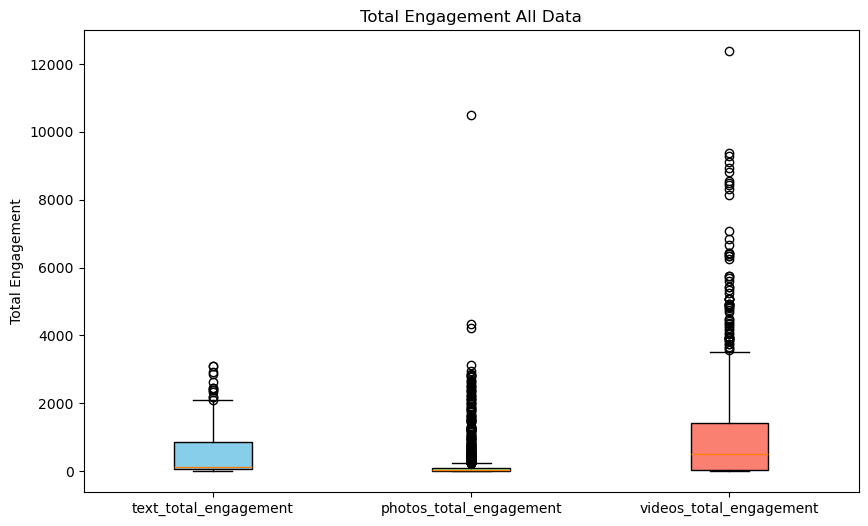

In [106]:
import matplotlib.pyplot as plt

total_engagement_df = pd.concat([
    text_df[['total_engagement']],
    photos_df[['total_engagement']],
    videos_df[['total_engagement']]
], axis=1)

total_engagement_df.columns = ['text_total_engagement', 'photos_total_engagement', 'videos_total_engagement']

# Creating Box-plot and filling it with one color to each type
plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [total_engagement_df[col].dropna() for col in total_engagement_df.columns],
    labels=total_engagement_df.columns,
    patch_artist=True
)

# Definindo cores para cada boxplot
colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Total Engagement All Data")
plt.ylabel("Total Engagement")
plt.show()


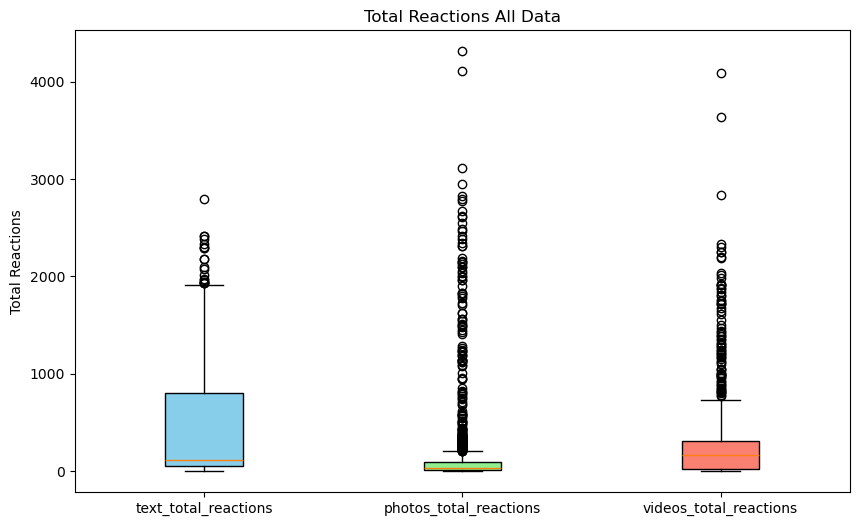

In [107]:
import matplotlib.pyplot as plt

total_reactions_df = pd.concat([
    text_df[['total_reactions']],
    photos_df[['total_reactions']],
    videos_df[['total_reactions']]
], axis=1)

total_reactions_df.columns = ['text_total_reactions', 'photos_total_reactions', 'videos_total_reactions']

# Creating Box-plot and filling it with one color to each type
plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [total_reactions_df[col].dropna() for col in total_reactions_df.columns],
    labels=total_reactions_df.columns,
    patch_artist=True  # permite preencher as caixas com cor
)

# Definindo cores para cada boxplot
colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Total Reactions All Data")
plt.ylabel("Total Reactions")
plt.show()


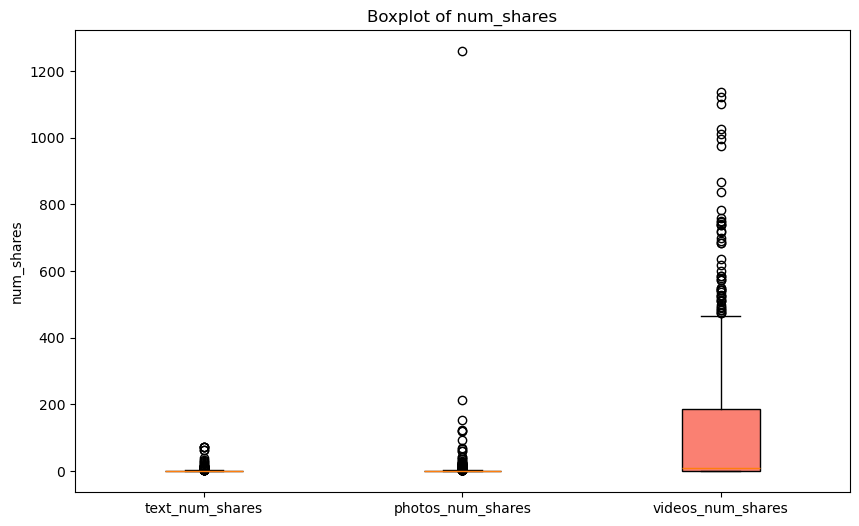

In [108]:
num_shares_df = pd.concat([
    text_df[['num_shares']],
    photos_df[['num_shares']],
    videos_df[['num_shares']]
], axis=1)

num_shares_df.columns = ['text_num_shares', 'photos_num_shares', 'videos_num_shares']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_shares_df[col].dropna() for col in num_shares_df.columns],
    labels=num_shares_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_shares")
plt.ylabel("num_shares")
plt.show()


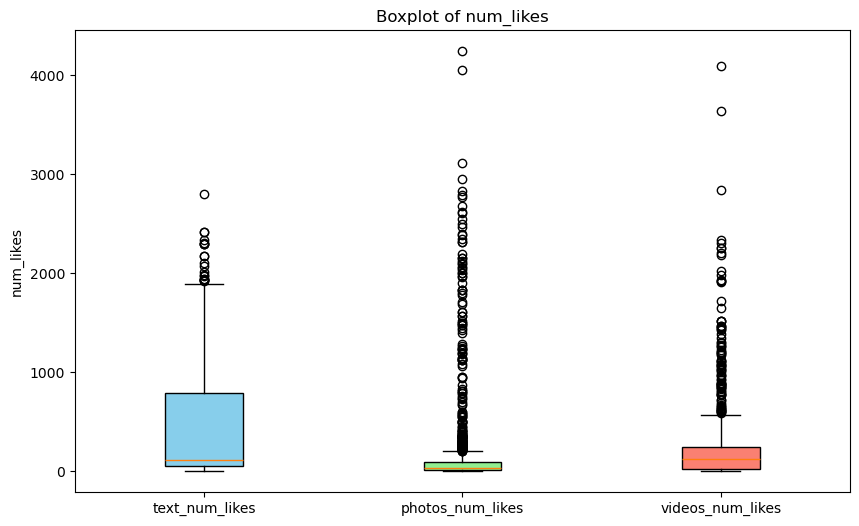

In [109]:
num_likes_df = pd.concat([
    text_df[['num_likes']],
    photos_df[['num_likes']],
    videos_df[['num_likes']]
], axis=1)

num_likes_df.columns = ['text_num_likes', 'photos_num_likes', 'videos_num_likes']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_likes_df[col].dropna() for col in num_likes_df.columns],
    labels=num_likes_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_likes")
plt.ylabel("num_likes")
plt.show()


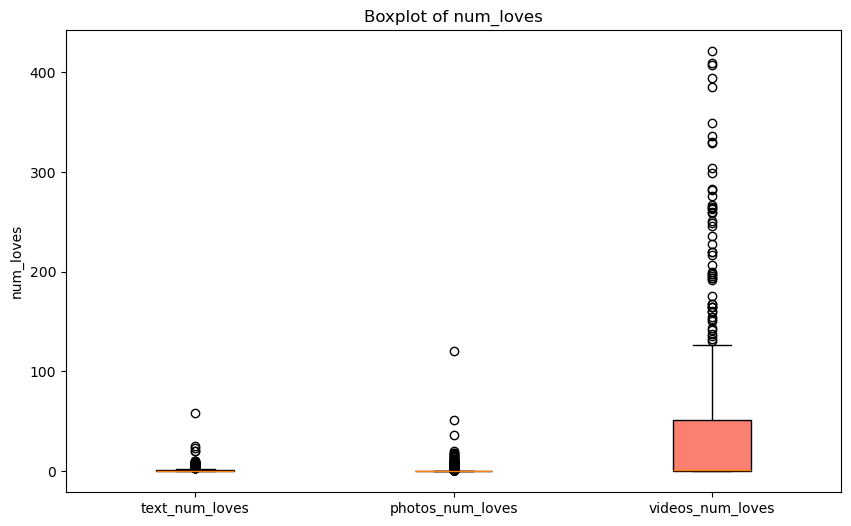

In [110]:
num_loves_df = pd.concat([
    text_df[['num_loves']],
    photos_df[['num_loves']],
    videos_df[['num_loves']]
], axis=1)

num_loves_df.columns = ['text_num_loves', 'photos_num_loves', 'videos_num_loves']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_loves_df[col].dropna() for col in num_loves_df.columns],
    labels=num_loves_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_loves")
plt.ylabel("num_loves")
plt.show()


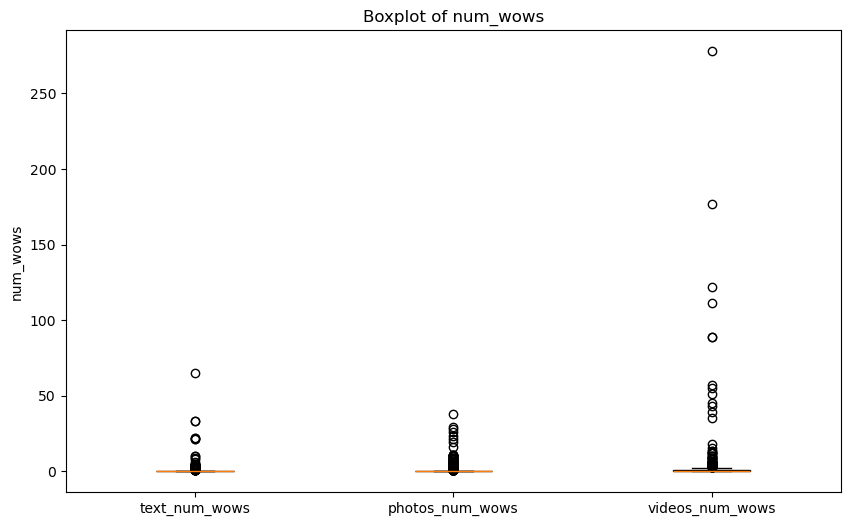

In [111]:
num_wows_df = pd.concat([
    text_df[['num_wows']],
    photos_df[['num_wows']],
    videos_df[['num_wows']]
], axis=1)

num_wows_df.columns = ['text_num_wows', 'photos_num_wows', 'videos_num_wows']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_wows_df[col].dropna() for col in num_wows_df.columns],
    labels=num_wows_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_wows")
plt.ylabel("num_wows")
plt.show()


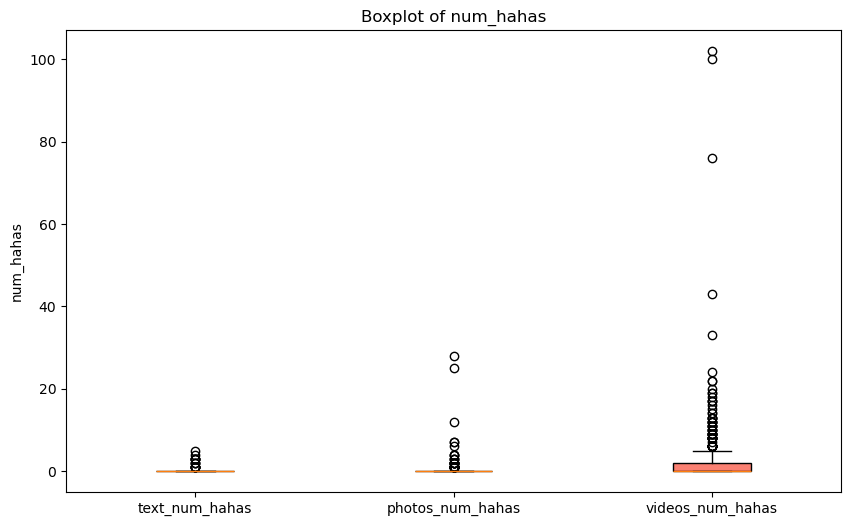

In [112]:
num_hahas_df = pd.concat([
    text_df[['num_hahas']],
    photos_df[['num_hahas']],
    videos_df[['num_hahas']]
], axis=1)

num_hahas_df.columns = ['text_num_hahas', 'photos_num_hahas', 'videos_num_hahas']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_hahas_df[col].dropna() for col in num_hahas_df.columns],
    labels=num_hahas_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_hahas")
plt.ylabel("num_hahas")
plt.show()


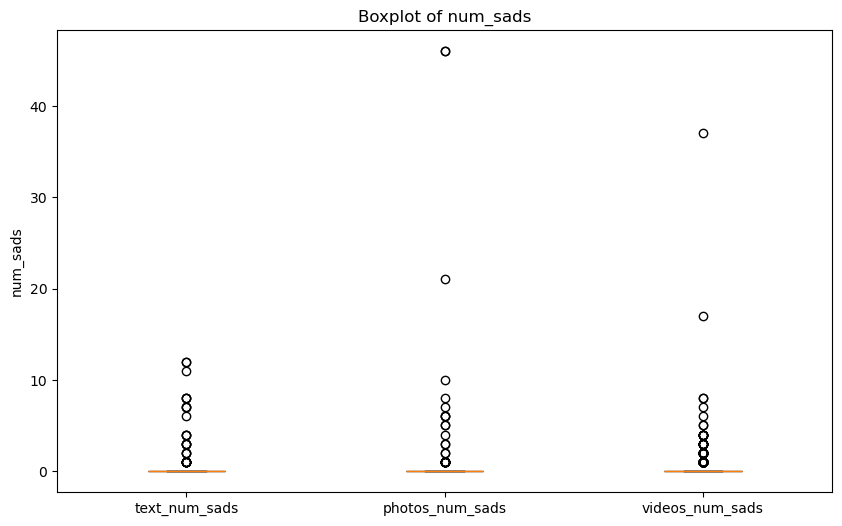

In [113]:
num_sads_df = pd.concat([
    text_df[['num_sads']],
    photos_df[['num_sads']],
    videos_df[['num_sads']]
], axis=1)

num_sads_df.columns = ['text_num_sads', 'photos_num_sads', 'videos_num_sads']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_sads_df[col].dropna() for col in num_sads_df.columns],
    labels=num_sads_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_sads")
plt.ylabel("num_sads")
plt.show()


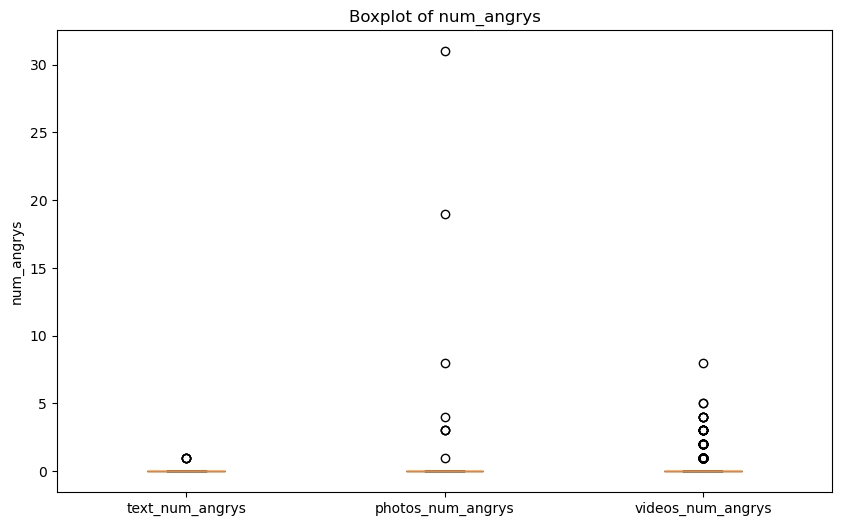

In [114]:
num_angrys_df = pd.concat([
    text_df[['num_angrys']],
    photos_df[['num_angrys']],
    videos_df[['num_angrys']]
], axis=1)

num_angrys_df.columns = ['text_num_angrys', 'photos_num_angrys', 'videos_num_angrys']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [num_angrys_df[col].dropna() for col in num_angrys_df.columns],
    labels=num_angrys_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of num_angrys")
plt.ylabel("num_angrys")
plt.show()


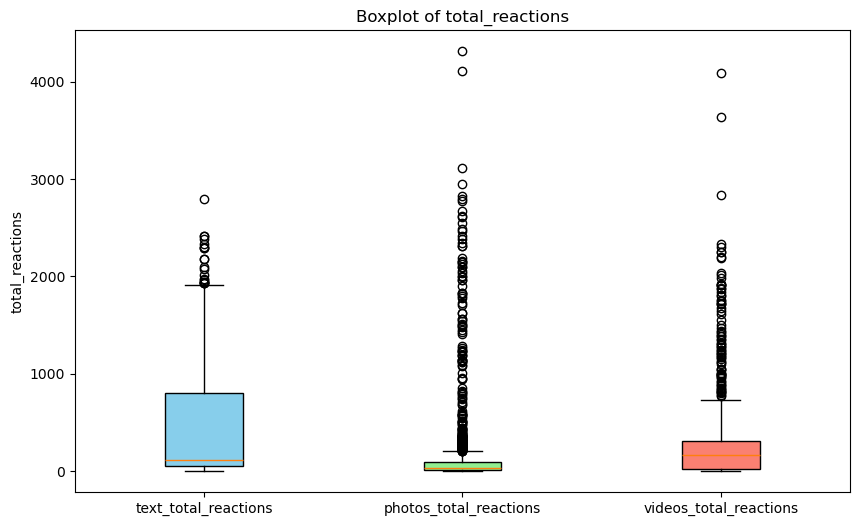

In [115]:
total_reactions_df = pd.concat([
    text_df[['total_reactions']],
    photos_df[['total_reactions']],
    videos_df[['total_reactions']]
], axis=1)

total_reactions_df.columns = ['text_total_reactions', 'photos_total_reactions', 'videos_total_reactions']

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    [total_reactions_df[col].dropna() for col in total_reactions_df.columns],
    labels=total_reactions_df.columns,
    patch_artist=True
)

colors = ['skyblue', 'lightgreen', 'salmon']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of total_reactions")
plt.ylabel("total_reactions")
plt.show()


##### Business Questions

<strong>In terms of reactions (likes, loves, etc.), how do videos perform when compared to other forms of content?</strong></br>
Videos have a lower performance when it comes to total reactions if compared to text and a better performance if compared to photos. However it is possible to see the presence of outliars in the text data since their mean and median are too distance from each other. It's also important to notice the presence of outliars in the video's data, once it also has this distance between mean and median, which indicates that some videos went viral.

<strong>Are they leading in terms of total engagement? What about in engagement on specific reactions?</strong></br>
In terms of total engagement, comments and shares in the other hand videos have a way better performance if compared to the other ones, although it is still possible to see the presence of huge outliars since the distance between median and mean is also too big.

<strong>What about in engagement on specific reactions? </strong></br>
Regarding reactions individually, both text and photos have a low performance, their means is based on big outliars since their median and their 75% quadrant is always 0. 

But  when it comes to normal Likes, Texts and Videos have a good performance with their median reaching 113 and 121 respectively.Videos, have also a relevant amount of love likes if compared with the others; video's mean for love likes is 37, while the other ones doesn't even reach 2, and 75% of the numbers of love likes on videos is under 51, while in the other ones it is around 1.


## Transforming

To transform this dataset, two kinds of transformations were run, QuantileTransformer and Scaler, both essential as the PCA expects the data to be scaled to be able to perform better.

The QuantileTransformer was chose because it performed better than the Power Transform with yeo-johnson. The skewness was way better corrected approaching normality in many cases

In [116]:
# Ploting function
def ploting_all(df):
   
    fig, ax = plt.subplots(figsize = (20, 10))
    ax.remove()

    
    columns_runned = 0

    for column in df:

        if columns_runned == 7:
            break

        columns_runned += 1
        
        plt.subplot(4, 4, columns_runned)
        
        if round(df[column].std(), 3) < 10:
            sns.histplot(df[column])
            
        elif df[column].std() < 60:
            sns.histplot(df[column],
                        binwidth = 30)
            
        elif df[column].std() < 500:
            sns.histplot(df[column],
                        binwidth = 60)
        else:
            sns.histplot(df[column],
                        binwidth = 200)
        
        
    plt.tight_layout()
    plt.show()

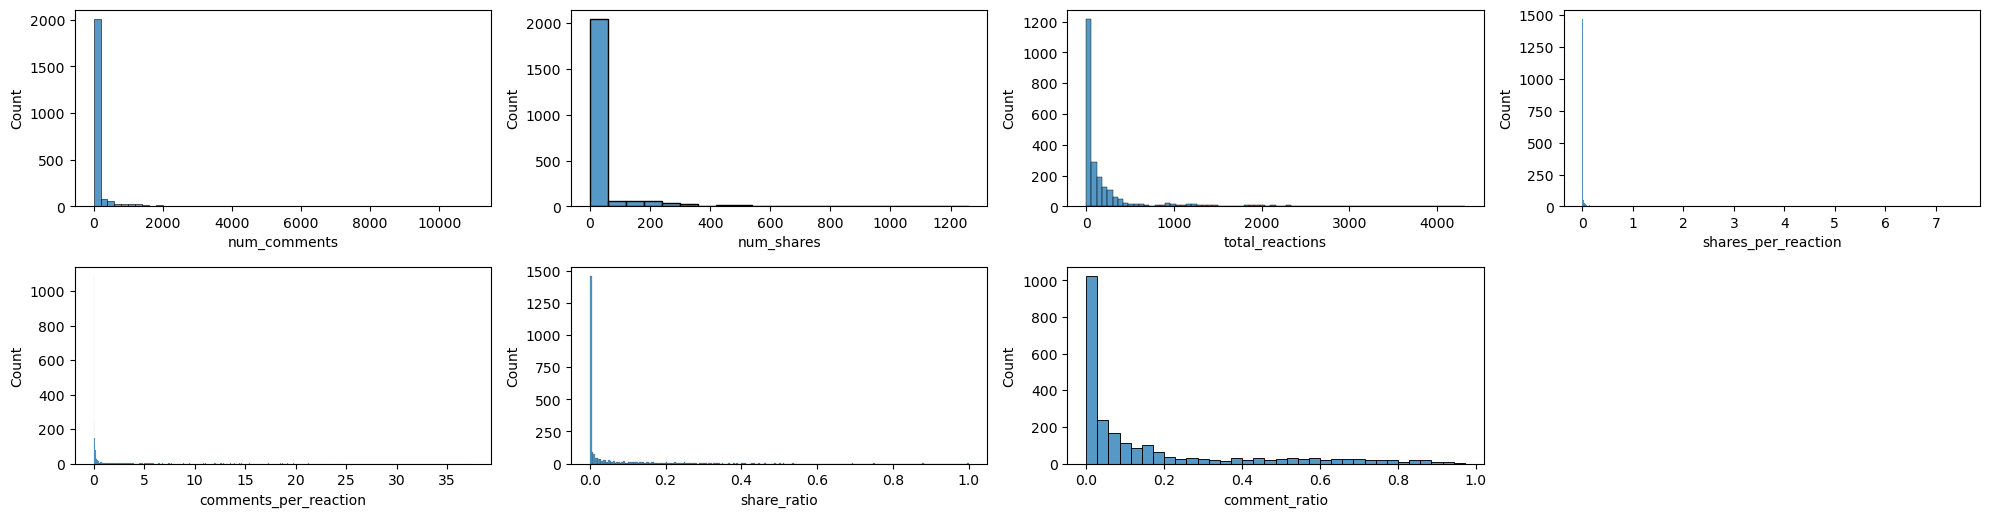

In [117]:
facebook_num_df = facebook_df[['num_comments', 'num_shares',
                               'total_reactions', 
                               'shares_per_reaction', 'comments_per_reaction', 
                               'share_ratio', 'comment_ratio', 'total_engagement', 'reaction_ratio'
                             ]]

ploting_all(facebook_num_df)

In [118]:
facebook_num_df.describe()

,num_comments,num_shares,total_reactions,shares_per_reaction,comments_per_reaction,share_ratio,comment_ratio,total_engagement,reaction_ratio
count,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000
mean,231.592718,39.535986,250.894581,0.154229,0.844295,0.037629,0.159831,522.023285,0.783914
std,851.523708,123.695257,499.659042,0.431625,2.613890,0.085109,0.235339,1136.553635,0.296862
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.739250
50%,4.000000,0.000000,54.500000,0.000000,0.049000,0.000000,0.046500,63.000000,0.923500
75%,24.000000,3.000000,215.000000,0.039750,0.245000,0.029000,0.193000,461.000000,0.992000
max,10960.000000,1260.000000,4315.000000,7.500000,37.478000,1.000000,0.972000,12377.000000,1.000000


In [119]:
(facebook_num_df == 0).mean()

num_comments             0.301439
num_shares               0.563506
total_reactions          0.019475
shares_per_reaction      0.567316
comments_per_reaction    0.301863
share_ratio              0.567316
comment_ratio            0.301863
total_engagement         0.018628
reaction_ratio           0.019475
dtype: float64

In [120]:
########################################
# unsupervised_scaler
########################################
def scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)

    print("Variance for each atribute", np.var(x_scaled, axis=0))
    
    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

Variance for each atribute [1. 1. 1. 1. 1. 1. 1. 1. 1.]


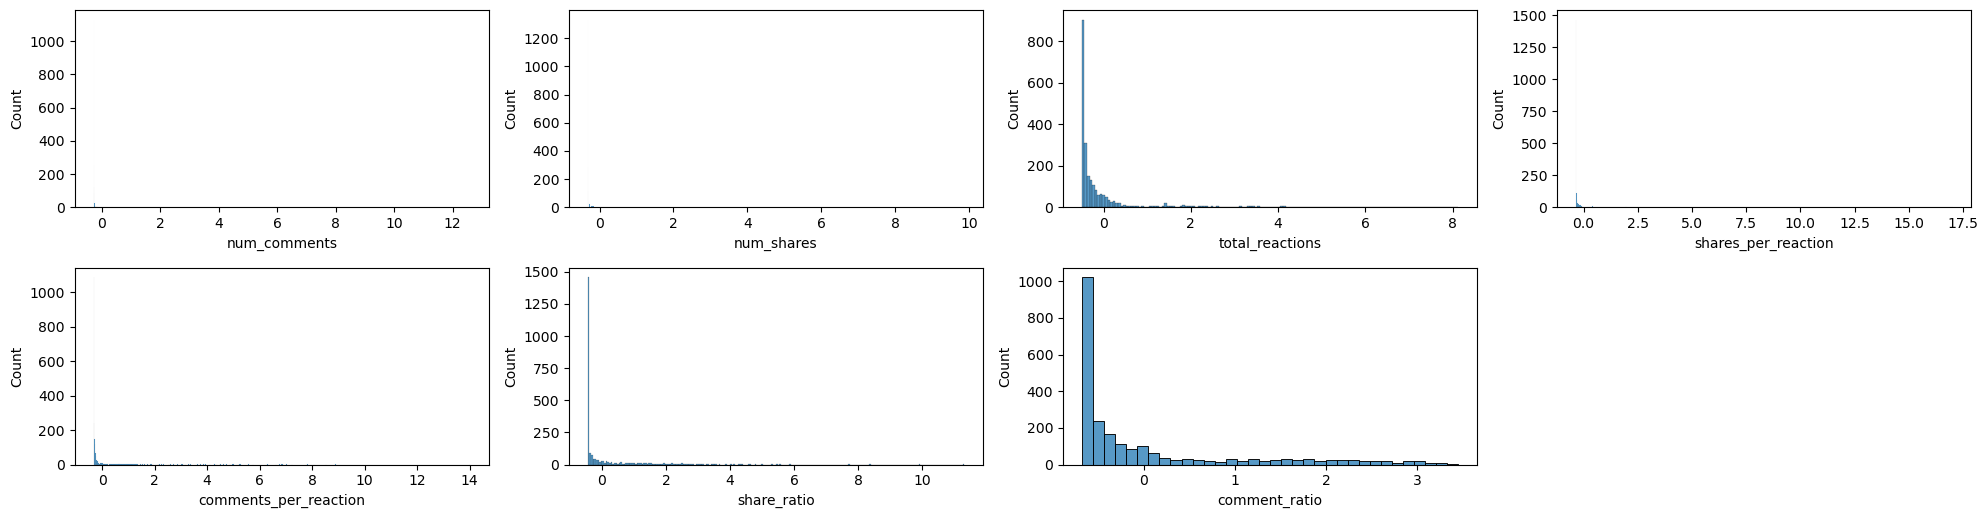

In [121]:
# Using UDF to scale the funcion
facebook_scaled_df = scaler(facebook_num_df)

ploting_all(facebook_scaled_df)

In [122]:
# Storaging skeewness
skew_bef_pt = facebook_scaled_df.skew()

In [123]:
pt = QuantileTransformer(output_distribution='normal')

facebook_qt = pt.fit_transform(facebook_scaled_df)

facebook_qt_df = pd.DataFrame(data   = facebook_qt,
                              columns = list(facebook_scaled_df.columns))
                              
facebook_qt_df.head()

,num_comments,num_shares,total_reactions,shares_per_reaction,comments_per_reaction,share_ratio,comment_ratio,total_engagement,reaction_ratio
0,0.185480,-5.199338,-0.803958,-5.199338,0.871679,-5.199338,0.882739,-0.595437,-0.764710
1,-0.110627,-5.199338,-0.912774,-5.199338,0.686350,-5.199338,0.689529,-0.835558,-0.542335
2,0.562796,0.658043,-0.577557,0.961455,1.006270,0.987652,1.024583,-0.227777,-0.929926
3,0.805692,-5.199338,-0.421111,-5.199338,1.152000,-5.199338,1.375320,0.000000,-1.018734
4,0.562796,-5.199338,-0.276998,-5.199338,0.888309,-5.199338,0.903301,-0.120731,-0.785569


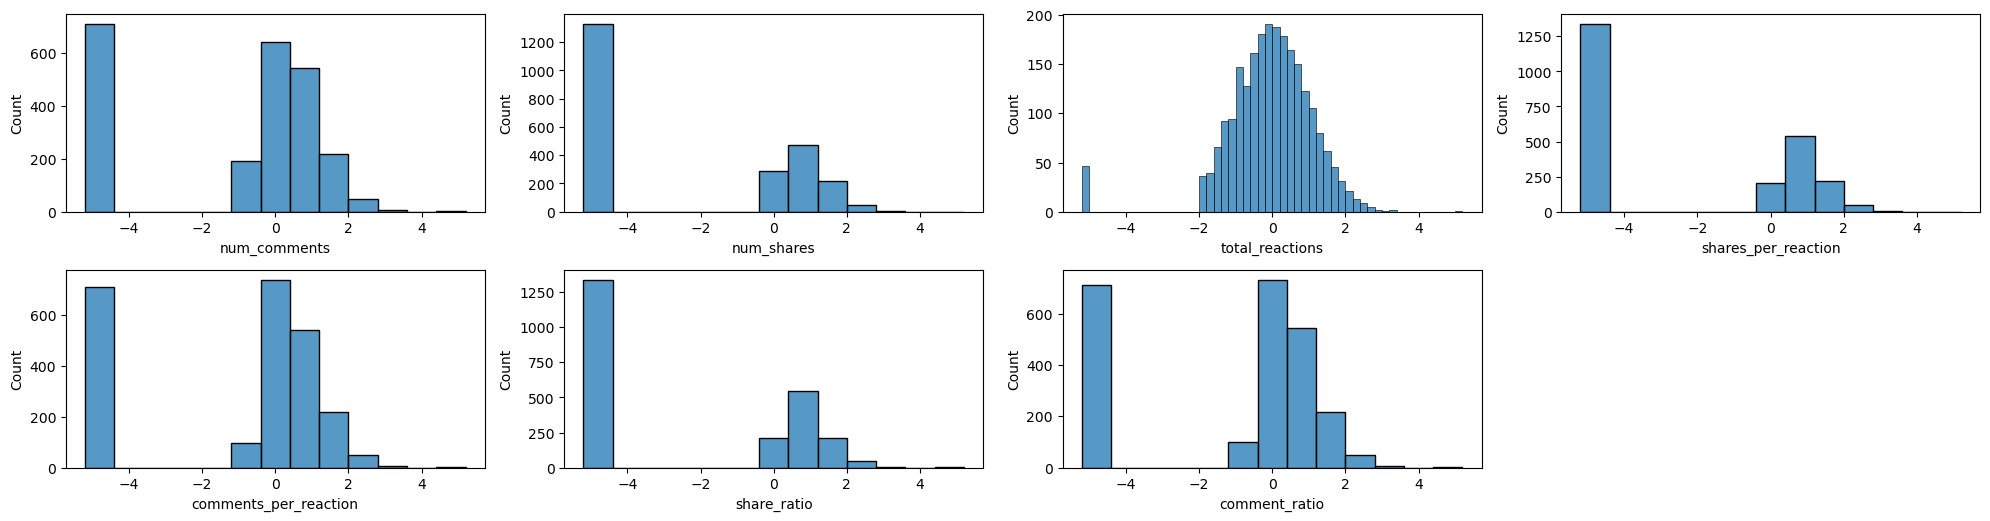

In [124]:
ploting_all(facebook_qt_df)

In [125]:
skew_bef_pt

num_comments             6.258604
num_shares               4.632488
total_reactions          3.302830
shares_per_reaction      6.121318
comments_per_reaction    5.540202
share_ratio              4.174736
comment_ratio            1.640677
total_engagement         4.197913
reaction_ratio          -1.444755
dtype: float64

In [126]:
facebook_qt_df.skew()

num_comments            -0.697918
num_shares               0.308200
total_reactions         -1.290337
shares_per_reaction      0.323880
comments_per_reaction   -0.696848
share_ratio              0.326043
comment_ratio           -0.696705
total_engagement        -1.257952
reaction_ratio           0.773420
dtype: float64

skew_bef_pt - skew_q_st_pt

## PCA

In [127]:
########################################
# scree_plot
########################################
def scree_plot(pca_object, export = False):
    # building a scree plot

    # setting plot size
    fig, ax = plt.subplots(figsize=(10, 8))
    features = range(pca_object.n_components_)


    # developing a scree plot
    plt.plot(features,
             pca_object.explained_variance_ratio_,
             linewidth = 2,
             marker = 'o',
             markersize = 10,
             markeredgecolor = 'black',
             markerfacecolor = 'grey')
    plt.axvline(x=1, color='red', linestyle='--', label='x = 1')

    
    # setting more plot options
    plt.title('Scree Plot')
    plt.xlabel('PCA feature')
    plt.ylabel('Explained Variance')
    plt.xticks(features)

    if export == True:
    
        # exporting the plot
        plt.savefig('./analysis_images/top_customers_correlation_scree_plot.png')
        
    # displaying the plot
    plt.show()

In [128]:
facebook_qt_df.head()

,num_comments,num_shares,total_reactions,shares_per_reaction,comments_per_reaction,share_ratio,comment_ratio,total_engagement,reaction_ratio
0,0.185480,-5.199338,-0.803958,-5.199338,0.871679,-5.199338,0.882739,-0.595437,-0.764710
1,-0.110627,-5.199338,-0.912774,-5.199338,0.686350,-5.199338,0.689529,-0.835558,-0.542335
2,0.562796,0.658043,-0.577557,0.961455,1.006270,0.987652,1.024583,-0.227777,-0.929926
3,0.805692,-5.199338,-0.421111,-5.199338,1.152000,-5.199338,1.375320,0.000000,-1.018734
4,0.562796,-5.199338,-0.276998,-5.199338,0.888309,-5.199338,0.903301,-0.120731,-0.785569


In [129]:
#Storaging the total engagement's mean
mean_engagement = facebook_df['total_engagement'].mean()

# Subseting the data that has a mean higher than the avarage too evaluate the correlation with engagement
facebook_df_videos_high_performance = facebook_df.loc[facebook_df['total_engagement'] >= mean_engagement]


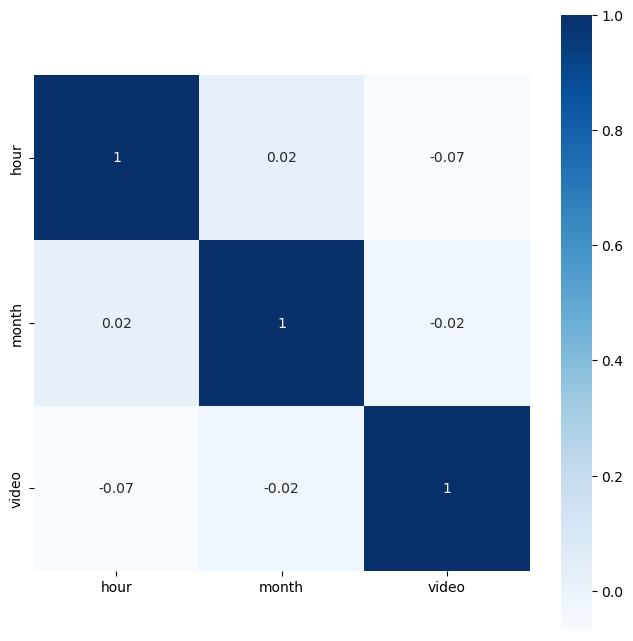

In [130]:
# setting plot size
fig, ax = plt.subplots(figsize = (8, 8))


# developing a correlation matrix object
df_corr = facebook_df_videos_high_performance[[
                             'hour', 'month', 'video'
    
                         ]].corr().round(decimals = 2)


# creating a correlation heatmap
sns.heatmap(data   = df_corr,
            cmap   = 'Blues',
            square = True,
            annot  = True)


# rendering the heatmap
plt.show()

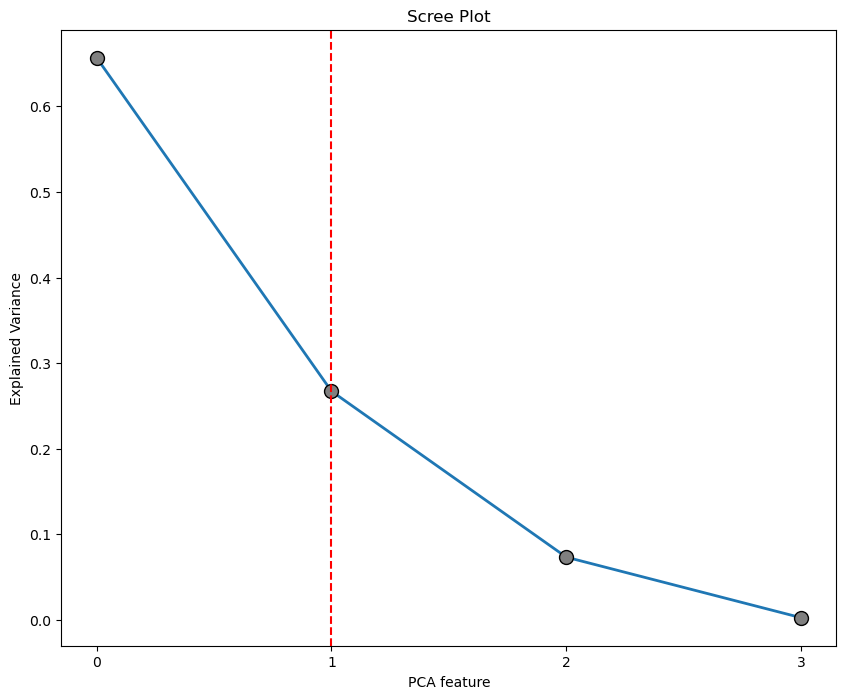

In [131]:
facebook_qt_pca_df = facebook_qt_df[[
                                    #'num_comments', 'num_shares',
                                    'total_reactions', 
                                    'shares_per_reaction', 
                                    'comments_per_reaction',
                                    #'reaction_ratio',
                                    #'share_ratio', 
                                    #'comment_ratio',
                                    'total_engagement'
                                  ]]


# INSTANTIATING a PCA object with no limit to principal components
pca = PCA(n_components = None,
          random_state = 702)

# Attention, this brings the variance all again
# FITTING and TRANSFORMING the scaled data
facebook_pca = pca.fit_transform(facebook_qt_pca_df)


# calling the scree_plot function
scree_plot(pca_object = pca)

In [132]:
# component number counter
component_number = 0

# looping over each principal component
for variance in pca.explained_variance_ratio_:
    component_number += 1
    
    print(f"PC {component_number}: {variance.round(3)}")

PC 1: 0.657
PC 2: 0.267
PC 3: 0.073
PC 4: 0.003


In [133]:
print(0.657 + 0.267 )

0.924


The cutoff point was chosen because both evaluations leaded to the quantity of 2 components. The scree plot changes it behavior at 1 (which is the second number of components since it starts in 0) with a drop in the marginal return of explained variance. And the variance evaluation also showed that with two PCAs it was possible to understand 92% of the data, which is really satisfactory.

It would be possible to increase this percentage of data representable even more including the other components. However it would probably decrease the quality of our principal components since they are not that representative.

In [134]:
# INSTANTIATING a new model using the first three principal components
pca = PCA(n_components = 2,
            random_state = 702)


# FITTING and TRANSFORMING the purchases_scaled
facebook_pca = pca.fit_transform(facebook_qt_pca_df)

In [135]:
# transposing pca components
facebook_pca_df = pd.DataFrame(np.transpose(pca.components_.round(decimals = 2)))


# naming rows as original features
facebook_pca_df = facebook_pca_df.set_index(facebook_qt_pca_df.columns)


# checking the result
print(facebook_pca_df)


# saving to Excel
facebook_pca_df.to_excel(excel_writer = 'engagement.xlsx',
                            index        = False)

                          0     1
total_reactions        0.22 -0.13
shares_per_reaction    0.75  0.65
comments_per_reaction  0.57 -0.74
total_engagement       0.25 -0.12


In [136]:
# naming each principal component
facebook_pca_df.columns = ['General_Engagement',
                           'Private_Engagement'
                           #, 'Low_Engagement'
                          ]


# checking the result
facebook_pca_df

,General_Engagement,Private_Engagement
total_reactions,0.22,-0.13
shares_per_reaction,0.75,0.65
comments_per_reaction,0.57,-0.74
total_engagement,0.25,-0.12


Analysing each of the PCAs, it was easy to see that the first one has positive relation with all the kinds of engagement. This PCA is associated with a strong amount of sharings and comments and has also a positive relation with total reactions. Besides, the relation with total_engagement is also good. This shows that this PCA is highly associated with a more generalized engagement without focusing in any specific one. Although some of the forms of engagement might seem stronger(shares and comments), it is important to notice that they are relative measures since they are the number of those engagements per total reactions.

The second one in the other hand has a positive relation only with the amount of shares per reactions. This indicates a high level of sharing specially if compared with the kinds of engagement.

Both of them involve a good amount of engagement, but the behavior that each component is representing is different. The guess is that the first PCA is associated with a community engagement, while the second is associated with a more private engagement.

Sharing is a more personal kind of engagement, other people cannot access your sharing unless they are the person you are sending the content to. Besides, it is usually in a more personal interaction than the other kinds of engagements, since you are sending to specific people who will be able to see it in their private chats.

In [137]:
# analyzing factor strengths per customer
loadings = pca.transform(facebook_qt_pca_df)


# converting to a DataFrame
loadings_df = pd.DataFrame(loadings)


# renaming columns
loadings_df.columns = facebook_pca_df.columns


# checking the results
loadings_df.head()

,General_Engagement,Private_Engagement
0,-1.079668,-3.097832
1,-1.269094,-2.917058
2,3.756886,0.707868
3,-0.688350,-3.427621
4,-0.838380,-3.235837


In [138]:
# checking variance amongst clusters
np.var(loadings_df)

C:\tools\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


General_Engagement    12.690020
Private_Engagement     5.163555
dtype: float64

In [139]:
loadings_scaled_df = scaler(loadings_df)

np.var(loadings_scaled_df)

Variance for each atribute [1. 1.]


C:\tools\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


General_Engagement    1.0
Private_Engagement    1.0
dtype: float64

In [140]:
facebook_qt_df

,num_comments,num_shares,total_reactions,shares_per_reaction,comments_per_reaction,share_ratio,comment_ratio,total_engagement,reaction_ratio
0,0.185480,-5.199338,-0.803958,-5.199338,0.871679,-5.199338,0.882739,-0.595437,-0.764710
1,-0.110627,-5.199338,-0.912774,-5.199338,0.686350,-5.199338,0.689529,-0.835558,-0.542335
2,0.562796,0.658043,-0.577557,0.961455,1.006270,0.987652,1.024583,-0.227777,-0.929926
3,0.805692,-5.199338,-0.421111,-5.199338,1.152000,-5.199338,1.375320,0.000000,-1.018734
4,0.562796,-5.199338,-0.276998,-5.199338,0.888309,-5.199338,0.903301,-0.120731,-0.785569
...,...,...,...,...,...,...,...,...,...
2357,-5.199338,0.797044,-0.247134,0.977096,-5.199338,1.340200,-5.199338,-0.227777,-0.385726
2358,1.483658,1.208843,0.648724,1.231280,1.674377,1.012474,1.762883,1.142791,-1.460531
2359,-5.199338,-5.199338,-0.392492,-5.199338,-5.199338,-5.199338,-5.199338,-0.490721,5.199338
2360,-5.199338,-5.199338,-1.362078,-5.199338,-5.199338,-5.199338,-5.199338,-1.401177,5.199338


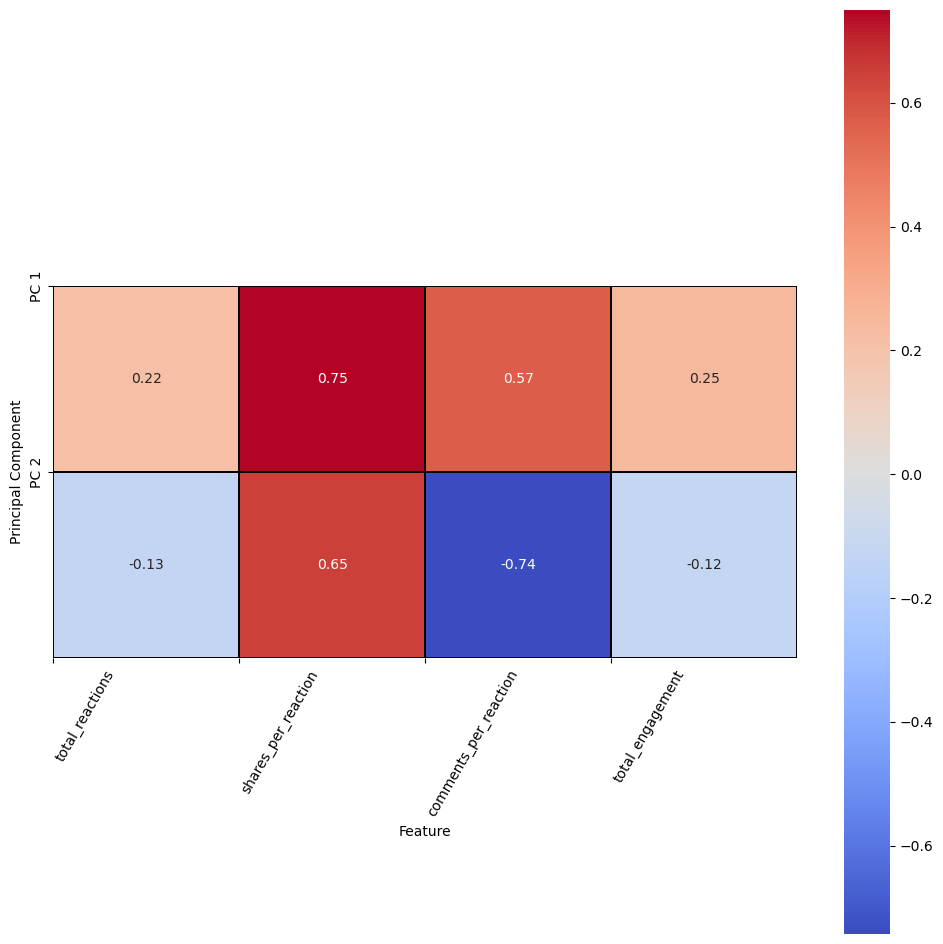

In [141]:
# setting plot size
fig, ax = plt.subplots(figsize = (12, 12))


# developing a PC to feature heatmap
sns.heatmap(pca.components_, 
            cmap = 'coolwarm',
            square = True,
            annot = True,
            linewidths = 0.1,
            linecolor = 'black')


# setting more plot options
plt.yticks([0, 1],
           ["PC 1", "PC 2"])

plt.xticks(range(0, 4),
           facebook_qt_pca_df.columns,
           rotation=60,
           ha='left')

plt.xlabel(xlabel = "Feature")
plt.ylabel(ylabel = "Principal Component")


# displaying the plot
plt.show()

# Clustering

In [142]:
loadings_scaled_df

,General_Engagement,Private_Engagement
0,-0.303081,-1.363275
1,-0.356256,-1.283721
2,1.054622,0.311514
3,-0.193232,-1.508406
4,-0.235348,-1.424007
...,...,...
2357,0.077957,2.324984
2358,1.388945,0.027038
2359,-1.249140,0.591573
2360,-1.371409,0.695293


In [143]:
# INSTANTIATING a k-Means object with five clusters
facebook_k_pca = KMeans(n_clusters   = 3    ,
                         n_init       = 'auto',
                         random_state = 702   )


# fitting the object to the data
facebook_k_pca.fit(loadings_scaled_df)


# converting the clusters to a DataFrame
facebook_kmeans_pca = pd.DataFrame({'Cluster': facebook_k_pca.labels_})




# checking the number of data points in each cluster
print(facebook_kmeans_pca.iloc[: , 0].value_counts())

Cluster
1    877
2    772
0    713
Name: count, dtype: int64


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


The ideal amount of clusters for this scenario is 3. This was decided based on the quantity of samples for each cluster. Compared to the other options this was the most balanced among the clusters. The difference in the number of samples of each cluster is not that big. The number 3 is a good amount to compare, interpret and explain. Besides that, compared with the other options it was the one with the best distinctions between the features.

In [144]:
# storing cluster centers
centroids_pca = facebook_k_pca.cluster_centers_


# converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(centroids_pca).round(decimals = 2)


# renaming principal components
centroids_pca_df.columns = [
                            'General Engagement',
                            'Private Engagement'
                           # ,'Low Engagement'
                           ]

# See how much people in a cluster match a group of characteristics
# checking results (clusters = rows, pc = columns)
centroids_pca_df.round(2)

,General Engagement,Private Engagement
0,-1.07,1.02
1,1.15,0.26
2,-0.31,-1.24


In [145]:
# concatenating cluster memberships with principal components
clst_pca_df = pd.concat([facebook_kmeans_pca,
                         loadings_df],
                         axis = 1)


cluster_names = {
                 0 : '1',
                 1 : '2',
                 2 : '3',
                }


# concatenating demographic information with pca-clusters
final_df = pd.concat([facebook_df.loc[ : , ['time', 'year', 'season', 'status_type']],
                      clst_pca_df.round(decimals = 2)],
                      axis = 1)



final_df['Cluster'].replace(cluster_names, inplace = True)


final_df.head(10)



C:\Users\yasca\AppData\Local\Temp\ipykernel_22972\2826489457.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['Cluster'].replace(cluster_names, inplace = True)


,time,year,season,status_type,Cluster,General_Engagement,Private_Engagement
0,late_night,2017,summer,photo,3,-1.08,-3.10
1,late_night,2017,summer,photo,3,-1.27,-2.92
2,late_night,2017,summer,photo,2,3.76,0.71
3,morning,2017,summer,photo,3,-0.69,-3.43
4,late_night,2017,summer,photo,3,-0.84,-3.24
5,morning,2017,summer,photo,3,-1.52,-2.49
6,morning,2017,summer,photo,2,3.60,0.60
7,morning,2017,summer,photo,1,-4.50,1.37
8,late_night,2017,summer,photo,3,-1.36,-2.71
9,late_night,2017,summer,photo,3,-0.96,-3.13


In [146]:
# renaming columns
final_df.columns = ['time', 'year', 'season', 'status_type', 'Cluster',
                    'General_Engagement',
                    'Private_Engagement'
                   # ,'Low Engagement'
                   ]


# checking the results
print(final_df.head(n = 5))

         time  year  season status_type Cluster  General_Engagement  \
0  late_night  2017  summer       photo       3               -1.08   
1  late_night  2017  summer       photo       3               -1.27   
2  late_night  2017  summer       photo       2                3.76   
3     morning  2017  summer       photo       3               -0.69   
4  late_night  2017  summer       photo       3               -0.84   

   Private_Engagement  
0               -3.10  
1               -2.92  
2                0.71  
3               -3.43  
4               -3.24  


In [147]:
print(final_df["Cluster"].unique())

['3' '2' '1']


In [148]:
# dynamic string with value counts for each demographic (cluster 1)
print(f"""\
 ----------------------------
| Cluster 1 - Private Photos |
 ----------------------------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '1']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 0 , :].to_string(dtype = False, name = False)}


status_type
------
{final_df.loc[ : , "status_type"][ final_df.loc[ : , 'Cluster' ] == '1']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
         
         
time
-------
{final_df.loc[ : , "time"][ final_df.loc[ : , 'Cluster' ] == '1']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}


year
-------
{final_df.loc[ : , "year"][ final_df.loc[ : , 'Cluster' ] == '1']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
  
  
season
------
{final_df.loc[ : , "season"][ final_df.loc[ : , 'Cluster' ] == '1']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
""")

 ----------------------------
| Cluster 1 - Private Photos |
 ----------------------------

Proportion of Observations
--------------------------
0.3


Centroids
---------
General Engagement   -1.07
Private Engagement    1.02


status_type
------
status_type
photo    0.63
text     0.08
video    0.29
         
         
time
-------
time
afternoon     0.03
late_night    0.37
morning       0.46
night         0.14


year
-------
year
2017    0.04
2018    0.05
2019    0.02
2020    0.01
2021    0.03
2022    0.14
2023    0.72
  
  
season
------
season
fall      0.12
spring    0.18
summer    0.33
winter    0.38



##### Status Type
The first Cluster was called Private Photos for presenting a strong relation with Photos while presenting a high relationship with Private Engagement. This relationship is over 0.63. This is more than the double of the other ones. This strong relationship leads us to believe that a great part of the data that can be explained by this cluster will be representing photo posts. This is an important conclusion since  photos are less interactive than texts but more interactive than videos, which naturally can lead to less engagement (Dehouche, 2020).

##### Common Post 
The most common time for this posting is during the morning reaching almost 50% of the cases. Besides is more related to posts made during summer and winter. To finish, the stronger relationship with year is 2023, but this is probably related to a bigger amount of data about the 2023 posts if compared with other years.

So probably a common post in this cluster would be a photo that generates more private engagement posted during the morning.

In [149]:
# dynamic string with value counts for each demographic (cluster 1)
print(f"""\
 ----------------------------
| Cluster 2 - General Videos |
 ----------------------------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '2']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 1 , :].to_string(dtype = False, name = False)}


status_type
------
{final_df.loc[ : , "status_type"][ final_df.loc[ : , 'Cluster' ] == '2']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
         
time
-------
{final_df.loc[ : , "time"][ final_df.loc[ : , 'Cluster' ] == '2']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}


year
-------
{final_df.loc[ : , "year"][ final_df.loc[ : , 'Cluster' ] == '2']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
  
  
season
------
{final_df.loc[ : , "season"][ final_df.loc[ : , 'Cluster' ] == '2']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
""")

 ----------------------------
| Cluster 2 - General Videos |
 ----------------------------

Proportion of Observations
--------------------------
0.37


Centroids
---------
General Engagement    1.15
Private Engagement    0.26


status_type
------
status_type
photo    0.36
text     0.13
video    0.51
         
time
-------
time
afternoon     0.03
late_night    0.36
morning       0.46
night         0.15


year
-------
year
2017    0.03
2018    0.03
2019    0.07
2020    0.07
2021    0.08
2022    0.12
2023    0.60
  
  
season
------
season
fall      0.19
spring    0.28
summer    0.28
winter    0.26



In [150]:
#Storaging the total engagement's mean
mean_engagement = facebook_df['total_engagement'].mean()

# Subseting the data that has a mean higher than the avarage too evaluate the correlation with engagement
facebook_df_videos_high_performance = facebook_df.loc[facebook_df['total_engagement'] >= mean_engagement]


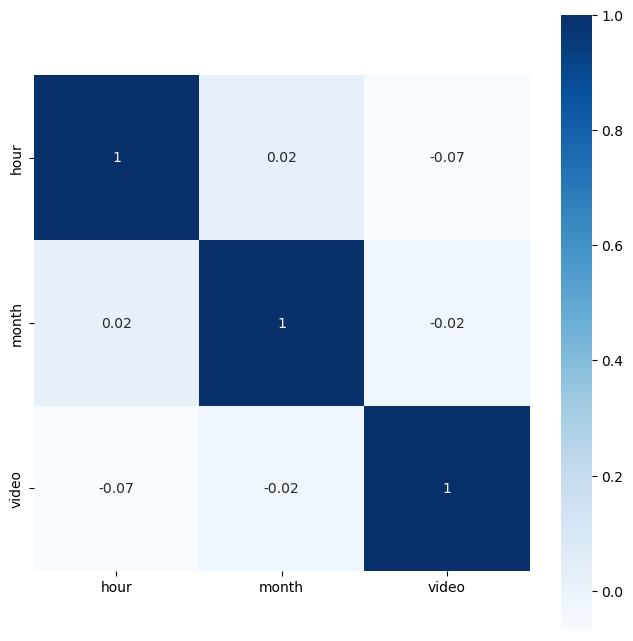

In [151]:
# setting plot size
fig, ax = plt.subplots(figsize = (8, 8))


# developing a correlation matrix object
df_corr = facebook_df_videos_high_performance[[
                             'hour', 'month', 'video'
    
                         ]].corr().round(decimals = 2)


# creating a correlation heatmap
sns.heatmap(data   = df_corr,
            cmap   = 'Blues',
            square = True,
            annot  = True)


# rendering the heatmap
plt.show()


##### Status Type
The second cluster was labeled General Videos due to its strong association with video content and high levels of general engagement. The correlation with video posts exceeds 0.50, nearly twice as high as the correlations observed in other clusters. This strong association suggests that a significant portion of the data explained by this cluster corresponds to video posts. This is a noteworthy finding, as videos are generally considered less interactive than text or photo content, yet they still tend to drive higher engagement levels. (Dehouche, 2020).

##### Common Post 
The most common time for this posting is during the morning reaching almost 50% of the cases. To finish, the stronger relationship with year is 2023, but this is probably related to a bigger amount of data about the 2023 posts if compared with other years. So probably a common post in this cluster would be a video that generates more general engagement posted during the morning.

##### Business Question 2: 

<strong>Are there any caveats to the effectiveness of videos (are there specific situations where they are more effective)?</strong>

As it is possible to see in this clustering, the videos seem to perform better when posted during the morning, during more hotter seasons as summer. However this relations are not that strong. This indicates that there is more things behind a video's performance than just the time it was posted. 

Of course that some moments might have more quantity of users using the social media. But the correlation matrix shows that the interaction between hour and months is very little with the performance of videos. By selecting only the videos with a performance above average and plotting it in a heat map with the time data, it showed week correlations. Regarding to "months" the correlation with video is negative and really weak, around 0.02. The hour feature goes in the same direction, a weak correlation of 0.07 and negative.

In the end both clustering and correlation shows the same thing: video's engagement are not that impacted by the time and season where they were posted.
 
This is probably happening because the performance of a video is more related to its content than to posting time aspects. However the present dataset doesn't contain any information about the video content. It contains only the data about time and engagement.

Therefore by the data we have available it is only possible to conclude that time of posting is not a that relevant aspect when it comes to video's engagement.


In [152]:
# dynamic string with value counts for each demographic (cluster 1)
print(f"""\
 ----------------------------
| Cluster 3 - Low Engagement |
 ----------------------------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '3']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[2 , :].to_string(dtype = False, name = False)}


status_type
------
{final_df.loc[ : , "status_type"][ final_df.loc[ : , 'Cluster' ] == '3']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
         
time
-------
{final_df.loc[ : , "time"][ final_df.loc[ : , 'Cluster' ] == '3']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}


year
-------
{final_df.loc[ : , "year"][ final_df.loc[ : , 'Cluster' ] == '3']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
  
  
season
------
{final_df.loc[ : , "season"][ final_df.loc[ : , 'Cluster' ] == '3']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
""")

 ----------------------------
| Cluster 3 - Low Engagement |
 ----------------------------

Proportion of Observations
--------------------------
0.33


Centroids
---------
General Engagement   -0.31
Private Engagement   -1.24


status_type
------
status_type
photo    0.70
text     0.21
video    0.09
         
time
-------
time
afternoon     0.03
late_night    0.39
morning       0.41
night         0.17


year
-------
year
2017    0.17
2018    0.13
2019    0.05
2020    0.07
2021    0.15
2022    0.09
2023    0.34
  
  
season
------
season
fall      0.31
spring    0.23
summer    0.19
winter    0.27



##### Status Type

The third Cluster was called Low Engagement for presenting a low relationship with both behavior: Private and General Engagement. This relationship with photo is 0.70, more than the double of the other ones. This strong relationship leads us to believe that a great part of the data that can be explained by this cluster will be representing photo posts. That conclusion can be easily explained by the fact that photos can be considered more interactive than videos, which naturally can lead to less engagement (Dehouche, 2020).



##### Common Post 
The most common time for this posting is during the morning reaching around 40% of the cases. Besides is more related to posts made during spring and winter. To finish, the stronger relationship with year is 2023, but this is probably related to a bigger amount of data about the 2023 posts if compared with other years.

So probably a common post in this cluster would be a photo that generates very little engagement of more reactions than other kinds of engagement and posted during the morning.

#### Clustering Comparison
The first cluster, called "Private Photo", have a deep relationship with Private Engagement (negative relationship with both comments_per_reaction and total_reactions) and with Photo.The second cluster, had a strong relationship with "General Videos" (positive relations in general with a strong relation with comments). The third cluster, did not demonstrate strong relationships with any of the PCA, and a strong relationship with Photos.

So summarize, the second cluster was the only one more related to videos, and demonstrated a more generalized kind of engagement (both private and public), while the other two clusters had a stronger realationship with photos and demonstrated or a more private engagement (not many comments and reactions with strong shares) or didn't relevant engagement.

# Logistic Regression


## Preparing Data

In [153]:
seasons_dummy = pd.get_dummies(data       = facebook_df['season'],
                               drop_first = True).astype(dtype = int)

time_dummy    = pd.get_dummies(data       = facebook_df['time'],
                               drop_first = True).astype(dtype = int)

facebook_df   = pd.concat([facebook_df, time_dummy, seasons_dummy], axis=1)

cluster_df    = pd.get_dummies(data       = final_df['Cluster'],
                               drop_first = True).astype(dtype = int)

In [154]:
loadings_scaled_df = pd.concat([loadings_scaled_df, facebook_df['video']], axis = 1)

## Logistic Regression Models

### Origin Features

#### Discovering Important Features

In [155]:
for val in facebook_df:
    print(f"""{val} 
+ """)

status_id 
+ 
status_type 
+ 
time_published 
+ 
num_comments 
+ 
num_shares 
+ 
num_likes 
+ 
num_loves 
+ 
num_wows 
+ 
num_hahas 
+ 
num_sads 
+ 
num_angrys 
+ 
video 
+ 
hour 
+ 
month 
+ 
year 
+ 
time 
+ 
season 
+ 
total_reactions 
+ 
total_engagement 
+ 
comment_ratio 
+ 
share_ratio 
+ 
reaction_ratio 
+ 
comments_per_reaction 
+ 
shares_per_reaction 
+ 
late_night 
+ 
morning 
+ 
night 
+ 
spring 
+ 
summer 
+ 
winter 
+ 


In [156]:
# Logistic Regression With old Features


# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ video   ~ 


+
num_comments 
+ 
num_shares 
+ 
num_loves 
+ 
num_wows 
+ 
num_sads 

+
comments_per_reaction 
+
hour 
+ 
month 
                            
                                        
                                                    """,
                                                    data    = facebook_df)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.422704
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:               Logit             Method:            MLE        
Dependent Variable:  video             Pseudo R-squared:  0.313      
Date:                2025-05-18 20:03  AIC:               2014.8544  
No. Observations:    2362              BIC:               2066.7598  
Df Model:            8                 Log-Likelihood:    -998.43    
Df Residuals:        2353              LL-Null:           -1452.4    
Converged:           1.0000            LLR p-value:       1.1021e-190
No. Iterations:      9.0000            Scale:             1.0000     
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             -0.6240   0.1225 -5.0928 0.0000 -0.8642 -0.3839
num_comments          -0.0012   0.0003 -3.5807 0.0003 -0.0019 -0.0006
num_shares             0.0146   0.0036  4.0266 0.0001  0.0075  0.0217
num_loves              0.0804   0.0125  6.4483 0.0000  0.0560  0.1048
num_wows              -0.0717   0.0117 -6.1324 0.0000 -0.0946 -0.0488
num_sads              -0.4914   0.1794 -2.7387 0.0062 -0.8431 -0.1397
comments_per_reaction  0.4393   0.0885  4.9638 0.0000  0.2659  0.6128
hour                  -0.0187   0.0084 -2.2223 0.0263 -0.0352 -0.0022
month                 -0.1269   0.0171 -7.4142 0.0000 -0.1604 -0.0933
=====================================================================

"""

In [157]:
# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ["time_published", "num_comments", "num_shares", 
                   "num_likes", "num_loves", "num_wows", "num_hahas", 
                   "num_sads", "num_angrys", "hour", "month", "year", 
                   "time", "season", "total_reactions"
                  ],
 

 # p-value significant variables only
 'logit_original_sig' : [ 
# FP:3
# FN: 103    
#'num_comments', 'num_shares', 'num_loves', 'num_wows', 'num_sads', 'comments_per_reaction', 'hour', 'month'
 
 
# FP: 2
# FN: 102
#'total_reactions', 'total_engagement', 'comments_per_reaction', 'shares_per_reaction', 'spring', 'summer', 'winter'     
     
# FP: 2
# FN: 102
#'total_reactions', 'total_engagement', 'comments_per_reaction', 'shares_per_reaction'

# FP:5
# FN: 100 
'share_ratio', 'comments_per_reaction', 'late_night', 'night', 'spring', 'summer', 'winter'
     

# FP:2
# FN: 105 
# 'num_shares', 'num_loves', 'num_wows', 'num_sads', 'hour', 'month'
   ],
}



In [158]:
candidate_dict["logit_original_sig"] 

['share_ratio',
 'comments_per_reaction',
 'late_night',
 'night',
 'spring',
 'summer',
 'winter']

In [159]:
# train/test split with the full model
logistic_data   =  facebook_df[ candidate_dict["logit_original_sig"] ]
logistic_target =  facebook_df['video']


# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            logistic_data,
            logistic_target,
            random_state = 702,
            test_size    = 0.25,
            stratify     = logistic_target)

In [160]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)



# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true  = y_test,
                            y_score = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {round(roc_score, ndigits = 3)}
""")


Train-Test Gap: 0.005
Test AUC Score: 0.716



In [161]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 406
False Positives: 5
False Negatives: 100
True Positives : 80



In [162]:
# zipping each feature name to its coefficient
model_values = zip(logistic_data[candidate_dict[ 'logit_original_sig'] ].columns,
                   model_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
model_lst = [('intercept', round(model_fit.intercept_[0], ndigits = 2))]


# printing out each feature-coefficient pair one by one
for val in model_values:
    model_lst.append(val)
    

# checking the results
for pair in model_lst:
    print(pair)

('intercept', -2.26)
('share_ratio', 3.01)
('comments_per_reaction', 0.97)
('late_night', -0.4)
('night', -0.89)
('spring', 1.1)
('summer', 1.12)
('winter', 1.43)


### Clusters

#### Logistic Regression With just the 2nd cluster - The best Model

In [163]:
cluster_part_1 = facebook_qt_df[[
    'num_comments', 'num_shares',
                                  # 'total_reactions', 
                                  # 'shares_per_reaction', 
                                   #'comments_per_reaction', 
                                   'share_ratio', 
                                   'comment_ratio', 
                                   'total_engagement']]
facebook_video = facebook_df[['video']]

cluster_df_2_1 = pd.concat([final_df, cluster_part_1, facebook_video], axis=1)

In [164]:
cluster_df_2_1

,time,year,season,status_type,Cluster,General_Engagement,Private_Engagement,num_comments,num_shares,share_ratio,comment_ratio,total_engagement,video
0,late_night,2017,summer,photo,3,-1.08,-3.10,0.185480,-5.199338,-5.199338,0.882739,-0.595437,0.0
1,late_night,2017,summer,photo,3,-1.27,-2.92,-0.110627,-5.199338,-5.199338,0.689529,-0.835558,0.0
2,late_night,2017,summer,photo,2,3.76,0.71,0.562796,0.658043,0.987652,1.024583,-0.227777,0.0
3,morning,2017,summer,photo,3,-0.69,-3.43,0.805692,-5.199338,-5.199338,1.375320,0.000000,0.0
4,late_night,2017,summer,photo,3,-0.84,-3.24,0.562796,-5.199338,-5.199338,0.903301,-0.120731,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,morning,2023,summer,video,1,0.28,5.28,-5.199338,0.797044,1.340200,-5.199338,-0.227777,1.0
2358,morning,2023,summer,video,2,4.95,0.06,1.483658,1.208843,1.012474,1.762883,1.142791,1.0
2359,morning,2023,summer,photo,1,-4.45,1.34,-5.199338,-5.199338,-5.199338,-5.199338,-0.490721,0.0
2360,afternoon,2023,summer,photo,1,-4.89,1.58,-5.199338,-5.199338,-5.199338,-5.199338,-1.401177,0.0


In [165]:
cluster_df_2 = cluster_df_2_1[cluster_df.iloc[ : , 0] == 1].copy()

cluster_df_2 = cluster_df_2[['General_Engagement', 'Private_Engagement', 'num_comments', 'num_shares',
                                  # 'total_reactions', 
                                  # 'shares_per_reaction', 
                                   #'comments_per_reaction', 
                                   'share_ratio', 
                                   'comment_ratio', 
                                   'total_engagement', 'video']]
cluster_df_2

,General_Engagement,Private_Engagement,num_comments,num_shares,share_ratio,comment_ratio,total_engagement,video
2,3.76,0.71,0.562796,0.658043,0.987652,1.024583,-0.227777,0.0
6,3.60,0.60,0.562796,0.551076,0.680013,0.781281,0.026349,0.0
16,3.21,0.92,-0.015055,0.316330,0.668987,0.387078,-0.284828,0.0
19,3.27,0.80,0.127052,0.316330,0.601439,0.466803,-0.163824,0.0
23,3.36,0.73,0.185480,0.316330,0.630254,0.623362,-0.216204,0.0
...,...,...,...,...,...,...,...,...
2350,3.84,0.52,0.970388,1.023003,0.622621,0.422483,0.941211,0.0
2351,4.71,0.16,1.333385,1.115905,0.981540,1.682167,0.889938,1.0
2356,5.32,0.66,1.334123,1.490335,1.674186,1.373375,0.963822,1.0
2358,4.95,0.06,1.483658,1.208843,1.012474,1.762883,1.142791,1.0


In [166]:
# selecting x- and y-data
x_data = cluster_df_2[['General_Engagement', 'Private_Engagement', 
                      #'num_comments', 'num_shares',
                                  # 'total_reactions', 
                                  # 'shares_per_reaction', 
                                   #'comments_per_reaction', 
                                   'share_ratio', 
                                   'comment_ratio', 
                                   'total_engagement']]
y_data = cluster_df_2['video']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.30,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [167]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702,
                                                class_weight = 'balanced'
                                               )


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true  = y_test,
                            y_score = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {round(roc_score, ndigits = 3)}
""")


Train-Test Gap: 0.017
Test AUC Score: 0.839



In [168]:
# storing cluster centers
centroids_pca = pd.DataFrame(data = facebook_k_pca.cluster_centers_)


# checking cluster centers
centroids_pca.round(decimals = 2)

,0,1
0,-1.07,1.02
1,1.15,0.26
2,-0.31,-1.24


In [169]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 118
False Positives: 11
False Negatives: 32
True Positives : 103



This Confusion Matrix shows the quantity of data that were correctely predicted, spliting them in four groups:
- True Negatives
- False Positives
- False Negatives
- True Positives

With this we are able to understand better how our model serves our intentions, is is possible to see how much of out critical point is actually being correctly predicted.

To this case scenario the critical point chosen was the False Positives, since they indicate that a content is a video when it is actually not. This is problematic since it can lead to inefficient allocation of resources, so in the end the company might end up focusing in the a contend that does not deliver the expected engagement. So the company would be giving wrong advises to its clients and making them lose money on campaigns with low engagement.

Among all the models evaluated, this one demonstrated the best overall performance. It achieved the highest AUC (Area Under the Curve) compared to the others. Although the critical point—False Positives—is slightly higher than in some of the alternative models discussed in this notebook, the overall accuracy compensates for it. This suggests that the model is more effective at correctly identifying video posts while minimizing incorrect classifications. In other words, it appears to be focusing on the right features when predicting video content, leading to more reliable and accurate outcomes.

### Why This Model Was Chosen

Although this model may appear limited because it only classifies posts within the second cluster, in this case, that limitation is actually an advantage rather than a drawback.

The dataset is highly heterogeneous and did not yield reliable results when modeled as a whole. However, segmenting the data and applying the model within a specific cluster, particularly one strongly associated with video content, led to meaningful insights. This approach helps highlight the characteristics that differentiate videos from other types of posts.

Importantly, the company doesn’t need to classify every single post; they already know the type of content they are publishing. What they truly need is to understand whether video posts are generating higher engagement and why. As long as the model provides reliable insights on that front, there's no reason to sacrifice performance just to achieve broader applicability across the entire dataset.

#### Logistic Regression with all the clusters

In [170]:
# selecting x- and y-data
x_data = cluster_df
y_data = facebook_df['video']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.30,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [171]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'liblinear',
                                                C            = 1,
                                                random_state = 702,
                                               
                                                class_weight = 'balanced')


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true  = y_test,
                            y_score = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {round(roc_score, ndigits = 3)}
""")


Train-Test Gap: 0.008
Test AUC Score: 0.683



In [172]:
# storing cluster centers
centroids_pca = pd.DataFrame(data = facebook_k_pca.cluster_centers_)


# checking cluster centers
centroids_pca.round(decimals = 2)

,0,1
0,-1.07,1.02
1,1.15,0.26
2,-0.31,-1.24


In [173]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 368
False Positives: 125
False Negatives: 82
True Positives : 134



### PCA

In [174]:

# selecting x- and y-data
x_data = facebook_pca
y_data = facebook_df['video']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [175]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)


print(f"""
Train-Test Gap: {train_acc - test_acc}
Test AUC Score: {roc_score}
""")


Train-Test Gap: 0.03700147421180311
Test AUC Score: 0.681021897810219



In [176]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 368
False Positives: 43
False Negatives: 96
True Positives : 84



In [177]:
# printing the predicted probabilities of 0 and 1, respectively
pd.DataFrame(data = model_fit.predict_proba(facebook_pca).round(decimals = 2),
             columns = ['Class 0', 'Class 1']).head(n = 5)

,Class 0,Class 1
0,0.87,0.13
1,0.87,0.13
2,0.51,0.49
3,0.87,0.13
4,0.87,0.13


In [178]:
# printing actual predictions (0 or 1)
pd.DataFrame(data    = model_fit.predict(facebook_pca),
             columns = ['Predicted Class']).head(n = 5)

,Predicted Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [179]:
# storing objects for predictions and true y values
true_y         = y_data
pred_probs     = pd.DataFrame(model_fit.predict_proba(facebook_pca)).round(decimals = 2)
pred_thresh_50 = pd.DataFrame(model_fit.predict(facebook_pca))

In [180]:
# combining the predictions into a DataFrame and renaming columns
prediction_df = pd.concat([true_y, pred_probs, pred_thresh_50], axis = 1)
prediction_df.columns = ['true_y', 'prob_0', 'prob_1', 'pred_thresh_50',]


# checking results
prediction_df.head(n = 15)

,true_y,prob_0,prob_1,pred_thresh_50
0,0.0,0.87,0.13,0.0
1,0.0,0.87,0.13,0.0
2,0.0,0.51,0.49,0.0
3,0.0,0.87,0.13,0.0
4,0.0,0.87,0.13,0.0
5,0.0,0.86,0.14,0.0
6,0.0,0.53,0.47,0.0
7,0.0,0.82,0.18,0.0
8,0.0,0.87,0.13,0.0
9,0.0,0.87,0.13,0.0


In [181]:
# To filter lines with true_y == 1
prediction_df_true_y = prediction_df.loc[prediction_df['true_y'] == 1]

prediction_df_not_y = prediction_df.loc[prediction_df['true_y'] == 0]

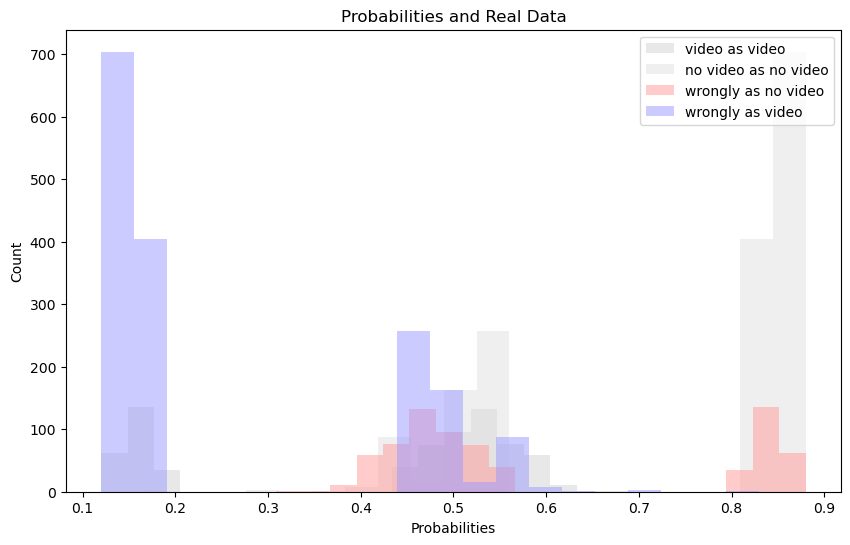

In [182]:
# Adjusting figure size
plt.figure(figsize=(10, 6))


# right ones
plt.hist(prediction_df_true_y['prob_1'], bins=20, alpha=0.5, label='video as video', color='#D3D3D3')  # Cinza claro
plt.hist(prediction_df_not_y['prob_0'], bins=20, alpha=0.5, label='no video as no video', color='#E0E0E0')  # Cinza ainda mais claro


# wrong ones
plt.hist(prediction_df_true_y['prob_0'], bins=20, alpha=0.5, label='wrongly as no video', color='#FF9999')  # Vermelho claro
plt.hist(prediction_df_not_y['prob_1'], bins=20, alpha=0.5, label='wrongly as video', color='#9999FF')  # Azul claro


plt.title('Probabilities and Real Data')
plt.xlabel('Probabilities')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

As an attempt to improve this model's performance, I tried to increase the sensibility of one the sides (positive or negative prediction), to make it possible, this plot was run to be able to identify properly when is the model predicting false negatives and false positives. This graph shows that many of the False predictions are located in the center, which might indicate that the company might benefit from a 3rd layer in the prediction, that looks closer to the ones located in this range of probability.

In [183]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = prediction_df['true_y'],
                             y_pred = prediction_df['pred_thresh_50']).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 1517
False Positives: 125
False Negatives: 365
True Positives : 355



In [184]:
# probability of 1 >= 0.25
prediction_df['pred_thresh'] = (prediction_df['prob_1'] >= 0.2).astype(dtype = int)

# checking results
prediction_df.tail(n = 10)

,true_y,prob_0,prob_1,pred_thresh_50,pred_thresh
2352,0.0,0.82,0.18,0.0,0
2353,1.0,0.44,0.56,1.0,1
2354,0.0,0.86,0.14,0.0,0
2355,1.0,0.42,0.58,1.0,1
2356,1.0,0.44,0.56,1.0,1
2357,1.0,0.42,0.58,1.0,1
2358,1.0,0.49,0.51,1.0,1
2359,0.0,0.82,0.18,0.0,0
2360,0.0,0.83,0.17,0.0,0
2361,1.0,0.50,0.50,1.0,1


In [185]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = prediction_df['true_y'],
                             y_pred = prediction_df['pred_thresh']).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 1109
False Positives: 533
False Negatives: 231
True Positives : 489



# REFERENCES

- Ryser, J. (2025, March 19). How important are social media likes? An expert weighs in. Gorevity. https://gorevity.com/how-important-are-social-media-likes-an-expert-weighs-in/


- OpenAI. (2025, April 17). ChatGPT response on handling division by zero in feature engineering for logistic regression [Large language model]. ChatGPT. https://chatgpt.com/share/680149d7-2d5c-800b-95b7-d8eb8a0f7783

- AgencyAnalytics. (n.d.). Social media shares – KPI definition, formula & tips. Retrieved April 17, 2025, from https://agencyanalytics.com/kpi-definitions/social-media-shares

- Dehouche, N. (2020). Dataset on usage and engagement patterns for Facebook Live sellers in Thailand. Data in Brief, 30, 105661. https://doi.org/10.1016/j.dib.2020.105661
